# Dataset Demo

The `mmwchanmod` packages has large datasets built from ray tracing data that can be used for experimentation in channel modeling. In this demo, you will learn how to:

* Download a dataset
* Print its configuration
* Convert the dataset to `MPChan`objects for MIMO computations
* Get basic statistics on the links in the dataset
* Plot conditional histograms for data exploration.
* Concatante datasets from multiple environments

## Loading the Packages

We first load some standard packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

To access the `mmwchanmod` package, you need to first add the package location to your path.  We add the path and then download the methods from the `mmwchanmod.datasets` sub-package.

In [2]:
path = os.path.abspath('..')
if not path in sys.path:
    sys.path.append(path)

from mmwchanmod.datasets.download import get_dataset, list_datasets

We can print the datasets available `list_datasets` command.  To print the datasets that can be downloaded from a remote server.

In [3]:
_ = list_datasets(src='remote')  # or simply list_datasets()

Available datasets:
   uav_boston
   uav_london
   uav_tokyo
   uav_moscow
   uav_beijing


We will explore the Boston dataset as one example.  The first time the `get_dataset` command is run, it retrieves the dataset from the remote server and returns the data in the dataset.   We see there are three components in each dataset:  a configuration data structure, training data dictionary and test data dictionary.

In [4]:
ds = get_dataset('uav_boston')
cfg = ds['cfg']
train_data = ds['train_data']
test_data = ds['test_data']

We can print the configuration as follows to get detail on the dataset.

In [5]:
print(cfg)

Description:   Boston UAV data
Date created:  30-10-2020
fc:              2.8000e+10 Hz
max path loss: 200.0
max num paths: 20
RX types:      ['Aerial', 'Terrestrial']


We can also list all the datasets that we have downloaded to the local machine.  The output of the command will depend on what you have downloaded prior to running this.  But, in this case, we see the `uav_boston` dataset.

In [17]:
_ = list_datasets(src='local')

Available datasets:
   uav_beijing
   uav_boston
   uav_london
   uav_lon_tok
   uav_moscow
   uav_tokyo


## Visualizing the Distance and Link State

The `train_data` and `test_data` are dictionaries with various arrays with one row per link.  For example, we can get the TX-RX vector on all the links and plot the CDF of the total distances as follows.

Number of links = 71622


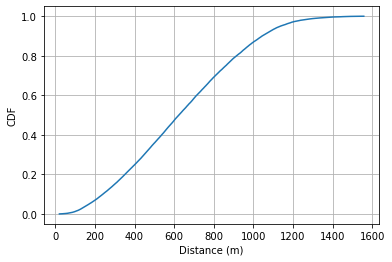

In [48]:
dvec = train_data['dvec']
d3d = np.sqrt(np.sum(dvec**2,axis=1))
nlink = len(d3d)

plt.plot(np.sort(d3d), np.linspace(0,1,nlink))
plt.grid()
plt.xlabel('Distance (m)')
plt.ylabel('CDF')

print('Number of links = %d' % nlink)

The dictionaries also include the link state indicating whether each link has:

*  NoLink:  Link has no paths
*  LOS:  Link has a LOS path, plus possibly NLOS paths
*  NLOS:  Link has only NLOS paths

We print the fraction of each link state type in the data set.

In [49]:
from mmwchanmod.common.constants import LinkState
link_state = train_data['link_state']

for i, ls in enumerate(LinkState.name):
    p = np.mean(link_state == i)
    print('%7s : %7.3f' % (ls,p))

 NoLink :   0.337
    LOS :   0.096
   NLOS :   0.567


We can plot the LOS probability as a function of the distance.  The `hist_mean` method computes the conditional probability for this purpose.

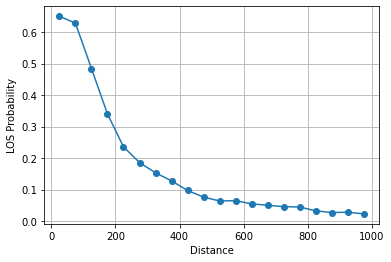

In [50]:
from mmwchanmod.learn.datastats import hist_mean

los = (link_state == LinkState.los_link)
bin_edges, dcnt, plos = hist_mean(d3d, los, bins=20, range=[0,1000])
bin_cen = (bin_edges[1:] + bin_edges[:-1])/2

plt.plot(bin_cen, plos, 'o-')
plt.grid()
plt.xlabel('Distance')
_ = plt.ylabel('LOS Probability')

Since this is a UAV data where the TX was flying, it is useful to plot the LOS probability as a function of both the horizontal and vertical distance.  We can do this with `hist_mean2d` function.

Text(0, 0.5, 'Vertical distance (m)')

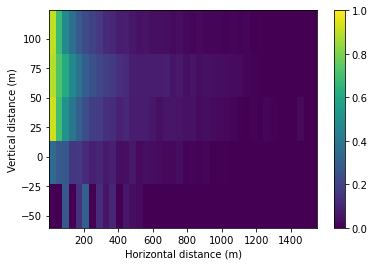

In [51]:
from mmwchanmod.learn.datastats import hist_mean2d

# Get the horizontal and vertical distance
dh = np.sqrt(dvec[:,0]**2 + dvec[:,1]**2)
dz = dvec[:,2]

# Get limits for the plot
xlim = np.array([np.min(dh), np.max(dh)])
zlim = np.array([np.min(dz), np.max(dz)])
         
# Compute the empirical probability
xedges, zedges, cnt, los_prob =\
    hist_mean2d(dh,dz,los,bins=[40,5],range=[xlim,zlim])
    
# Plot the results    
plt.imshow(np.flipud(los_prob.T),aspect='auto',\
               extent=[np.min(xedges),np.max(xedges),np.min(zedges),np.max(zedges)],\
               vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('Horizontal distance (m)')
plt.ylabel('Vertical distance (m)')

## Separating Statistics by RX Type

The package enables considering different types of receivers.  In the UAV dataset, there are two RX types: 

* aerial base stations mounted on rooftops directed for UAVs
* terrestrial base stations on the ground designed for terrestrial links but could be used for UAVs

We can plot the LOS probability separately for these two types as follows.  There are some gaps in the histogram since there were no TXs at certain altitudes in this data.

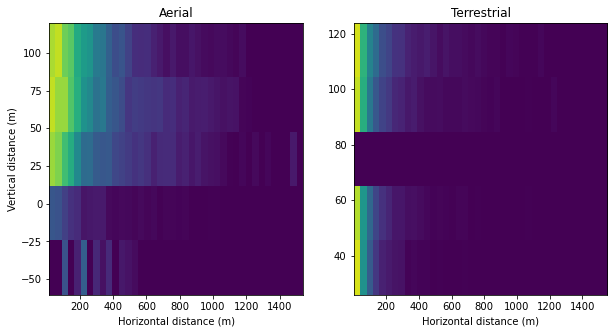

In [52]:
rx_type = train_data['rx_type']
ntypes = len(cfg.rx_types)

fig, ax = plt.subplots(1,ntypes, figsize=(10,5))

for i in range(ntypes):
    I0 = np.where(train_data['rx_type'] == i)[0]

    xlim = np.array([np.min(dh[I0]), np.max(dh[I0])])
    zlim = np.array([np.min(dz[I0]), np.max(dz[I0])])

    # Compute the empirical probability
    xedges, zedges, cnt, los_prob = hist_mean2d(dh[I0],dz[I0],los[I0],\
                                                  bins=[40,5],range=[xlim,zlim])

    ax[i].imshow(np.flipud(los_prob.T),aspect='auto',\
                   extent=[np.min(xedges),np.max(xedges),np.min(zedges),np.max(zedges)],\
                   vmin=0, vmax=1)
    
    ax[i].set_xlabel('Horizontal distance (m)')
    if (i == 0):
        ax[i].set_ylabel('Vertical distance (m)')
    ax[i].set_title(cfg.rx_types[i])

## Plotting the Omni-Directional Path Loss and Delay

For several other statistics,  we first convert the data arrays to a list of multipath channel objects, `MPChan`.

In [53]:
from mmwchanmod.learn.datastats import data_to_mpchan
chan_list, link_state = data_to_mpchan(train_data, cfg)

Once it is an lis of `MPChan` objects, we can compute various statistics such as the RMS delay spread.

In [54]:
nlink = len(chan_list)
pl_omni = np.zeros(nlink)
rms_dly = np.zeros(nlink)
for i in range(nlink):
    pl_omni[i] = chan_list[i].comp_omni_path_loss()
    rms_dly[i] = chan_list[i].rms_dly()

We now plot the delay spread as a function of the distance.

Text(0, 0.5, 'RMS delay spread (ns)')

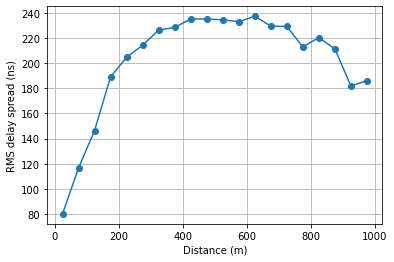

In [55]:
# Find links on which there is at least one path
I = np.where(link_state != LinkState.no_link)[0]


bin_edges, dcnt, rms_dly_mean = hist_mean(d3d[I], rms_dly[I], bins=20, range=[0,1000])
bin_cen = (bin_edges[1:] + bin_edges[:-1])/2

# Convert to ns
rms_dly_mean = rms_dly_mean*1e9
plt.plot(bin_cen, rms_dly_mean, 'o-')
plt.grid()
plt.xlabel('Distance (m)')
plt.ylabel('RMS delay spread (ns)')


We plot the omni-directional path loss separately for LOS and NLOS links.

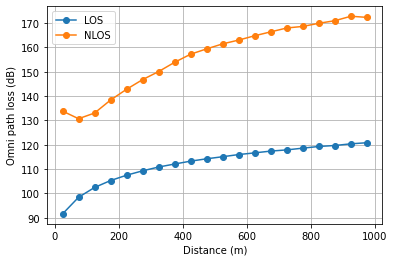

In [56]:
ls_plot = [LinkState.los_link, LinkState.nlos_link]

for i, ls in enumerate(ls_plot):
    I = np.where(link_state == ls)[0]
    bin_edges, dcnt, pl_mean = hist_mean(d3d[I], pl_omni[I], bins=20, range=[0,1000])
    bin_cen = (bin_edges[1:] + bin_edges[:-1])/2

    plt.plot(bin_cen, pl_mean, 'o-')

plt.grid()
plt.legend(['LOS', 'NLOS'])
plt.xlabel('Distance (m)')
_  = plt.ylabel('Omni path loss (dB)')

There is plenty of other stats that you can play around with including the angles of the paths.

## Concatenating Datasets

Sometimes it is useful to concatante datasets to train on the union of environments.  The following code will create a dataset combining the London and Tokyo cities.

In [14]:
from mmwchanmod.datasets.download import concat_datasets
ds_names = ['uav_london', 'uav_tokyo']

# Load the datasets to the local machine
# The return_data option indicates to just download the data and not output the contents
for ds_name in ds_names:
    get_dataset(ds_name, return_data=False)
    
# Concantante datasets    
_ = concat_datasets(ds_names, out_name='uav_lon_tok')


Data file C:\Users\sdran\Google Drive (sr663@nyu.edu)\RanganGroup\Simulations\mmwchanmod-nyu\mmwchanmod\datasets\..\..\data\uav_london.p already available
Data file C:\Users\sdran\Google Drive (sr663@nyu.edu)\RanganGroup\Simulations\mmwchanmod-nyu\mmwchanmod\datasets\..\..\data\uav_tokyo.p already available
uav_london: train:  74659 links, test: 24886 links
uav_tokyo : train:  176400 links, test: 58800 links
Total     : train:  251059 links, test: 83686 links
Concatanated uav_lon_tok.p


We can now verify that the concatanted dataset is in the local data folder.

In [16]:
_ = list_datasets(src='local')

Available datasets:
   uav_beijing
   uav_boston
   uav_london
   uav_lon_tok
   uav_moscow
   uav_tokyo
